In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import SMOTE

In [3]:
#Function to cound number of sentencees and words in a teext file
def get_sentence_word_count(text_list):
    sent_count = 0
    word_count = 0
    vocab = {}
    for text in text_list:
        sentences = sent_tokenize(str(text).lower())
        sent_count = sent_count + len(sentences)
        for sentence in sentences:
            words = word_tokenize(sentence)
            for word in words:
                if(word in vocab.keys()):
                    vocab[word] = vocab[word] +1
                else:
                    vocab[word] =1
    word_count = len(vocab.keys())
    return sent_count,word_count


In [4]:
# reading clinical data from csv file and save it as a pandas dataframe
clinical_text_df = pd.read_csv("/content/mtsamples.csv")

print(clinical_text_df.columns)
clinical_text_df.head(5)

Index(['Unnamed: 0', 'description', 'medical_specialty', 'sample_name',
       'transcription', 'keywords'],
      dtype='object')


,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [5]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
#Counting the number of sentences and words in the whole Transcription data
clinical_text_df = clinical_text_df[clinical_text_df['transcription'].notna()]
sent_count,word_count= get_sentence_word_count(clinical_text_df['transcription'].tolist())
print("Number of sentences in transcriptions column: "+ str(sent_count))
print("Number of unique words in transcriptions column: "+str(word_count))


#finding number of samples in each classes(medical speciality)
data_categories  = clinical_text_df.groupby(clinical_text_df['medical_specialty'])
i = 1
print('===========Original Categories =======================')
for catName,dataCategory in data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1
print('==================================')

Number of sentences in transcriptions column: 140235
Number of unique words in transcriptions column: 35805
===========Original Categories =======================
Cat:1  Allergy / Immunology : 7
Cat:2  Autopsy : 8
Cat:3  Bariatrics : 18
Cat:4  Cardiovascular / Pulmonary : 371
Cat:5  Chiropractic : 14
Cat:6  Consult - History and Phy. : 516
Cat:7  Cosmetic / Plastic Surgery : 27
Cat:8  Dentistry : 27
Cat:9  Dermatology : 29
Cat:10  Diets and Nutritions : 10
Cat:11  Discharge Summary : 108
Cat:12  ENT - Otolaryngology : 96
Cat:13  Emergency Room Reports : 75
Cat:14  Endocrinology : 19
Cat:15  Gastroenterology : 224
Cat:16  General Medicine : 259
Cat:17  Hematology - Oncology : 90
Cat:18  Hospice - Palliative Care : 6
Cat:19  IME-QME-Work Comp etc. : 16
Cat:20  Lab Medicine - Pathology : 8
Cat:21  Letters : 23
Cat:22  Nephrology : 81
Cat:23  Neurology : 223
Cat:24  Neurosurgery : 94
Cat:25  Obstetrics / Gynecology : 155
Cat:26  Office Notes : 50
Cat:27  Ophthalmology : 83
Cat:28  Orthoped

In [7]:
#removing classes which have less than 50 samples
filtered_data_categories = data_categories.filter(lambda x:x.shape[0] > 50)
final_data_categories = filtered_data_categories.groupby(filtered_data_categories['medical_specialty'])
i=1
print('============Reduced Categories ======================')
for catName,dataCategory in final_data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1

print('============ Reduced Categories ======================')

============Reduced Categories ======================
Cat:1  Cardiovascular / Pulmonary : 371
Cat:2  Consult - History and Phy. : 516
Cat:3  Discharge Summary : 108
Cat:4  ENT - Otolaryngology : 96
Cat:5  Emergency Room Reports : 75
Cat:6  Gastroenterology : 224
Cat:7  General Medicine : 259
Cat:8  Hematology - Oncology : 90
Cat:9  Nephrology : 81
Cat:10  Neurology : 223
Cat:11  Neurosurgery : 94
Cat:12  Obstetrics / Gynecology : 155
Cat:13  Ophthalmology : 83
Cat:14  Orthopedic : 355
Cat:15  Pain Management : 61
Cat:16  Pediatrics - Neonatal : 70
Cat:17  Psychiatry / Psychology : 53
Cat:18  Radiology : 273
Cat:19  SOAP / Chart / Progress Notes : 166
Cat:20  Surgery : 1088
Cat:21  Urology : 156
============ Reduced Categories ======================


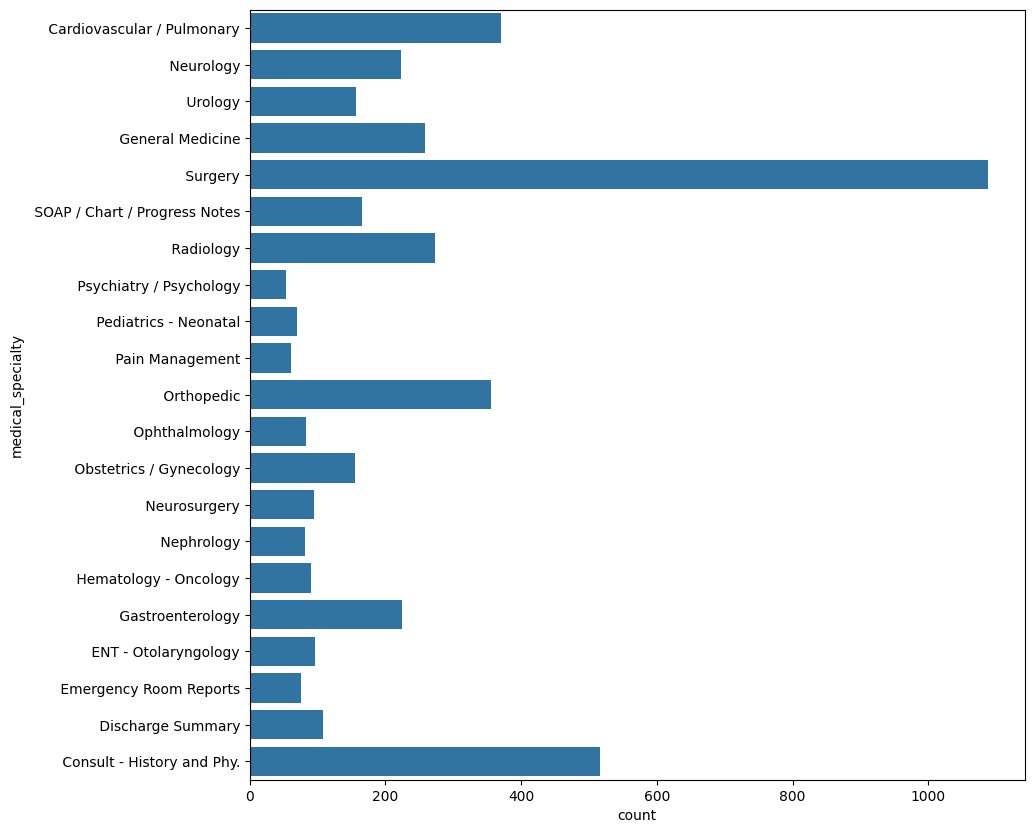

In [8]:
#plotting histogram of meedical categor vs sample count
plt.figure(figsize=(10,10))
sns.countplot(y='medical_specialty', data = filtered_data_categories)
plt.show()

In [9]:
data = filtered_data_categories[['transcription', 'medical_specialty']]
data = data.drop(data[data['transcription'].isna()].index)
data.shape

(4597, 2)

In [ ]:
data.iloc[1]['transcription']

' the left ventricular cavity size and wall thickness appear normal the wall motion and left ventricular systolic function appears hyperdynamic with estimated ejection fraction of  to  there is nearcavity obliteration seen there also appears to be increased left ventricular outflow tract gradient at the mid cavity level consistent with hyperdynamic left ventricular systolic function there is abnormal left ventricular relaxation pattern seen a well a elevated left atrial pressure seen by doppler examination the left atrium appears mildly dilated the right atrium and right ventricle appear normal the aortic root appears normal the aortic valve appears calcified with mild aortic valve stenosis calculated aortic valve area is  cm square with a maximum instantaneous gradient of  and a mean gradient of  mm there is mitral annular calcification extending to leaflet and supportive structure with thickening of mitral valve leaflet with mild mitral regurgitation the tricuspid valve appears norma

In [ ]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75, use_idf=True, smooth_idf=True, max_features=1000)
tfIdfMat  = vectorizer.fit_transform(data['transcription'].tolist() )
feature_names = sorted(vectorizer.get_feature_names_out())


In [ ]:
print(feature_names[800:-1])

['specimen', 'speech', 'spinal', 'spine', 'sponge', 'stable', 'stable condition', 'stage', 'standard', 'started', 'state', 'stated', 'status', 'status post', 'stenosis', 'stent', 'sterile', 'sterile dressing', 'sterile fashion', 'steristrips', 'stitch', 'stomach', 'stool', 'straight', 'strength', 'stress', 'stroke', 'structure', 'study', 'subcutaneous', 'subcutaneous tissue', 'subcuticular', 'subsequently', 'suction', 'suctioned', 'suite', 'superior', 'supine', 'supine position', 'supple', 'surface', 'surgery', 'surgical', 'surgical history', 'suture', 'sutures', 'swelling', 'symptom', 'symptoms', 'syndrome', 'systems', 'systolic', 'table', 'taken', 'taken operating', 'taken operating room', 'taken recovery', 'taking', 'tear', 'technique', 'temperature', 'temporal', 'tenderness', 'tendon', 'test', 'testing', 'therapy', 'think', 'thought', 'throat', 'thyroid', 'tibial', 'time', 'time wa', 'tip', 'tissue', 'tissue wa', 'today', 'toe', 'told', 'tolerated', 'tolerated procedure', 'tolerate

In [ ]:
# creating a word embedding based on pretarined weights
from gensim.models import KeyedVectors

# Path to the BioWordVec embeddings file
path_to_biowordvec = 'path/to/biowordvec.bin'

# Load BioWordVec embeddings
biowordvec_model = KeyedVectors.load_word2vec_format(path_to_biowordvec, binary=True)

In [10]:
# removing certain classes which has lot of ambiguity in the transcript, as it doesnt belong to a specific medical specialityy
filtered_data_categories['medical_specialty'] =filtered_data_categories['medical_specialty'].apply(lambda x:str.strip(x))
mask = filtered_data_categories['medical_specialty'] == 'Surgery'
filtered_data_categories = filtered_data_categories[~mask]
final_data_categories = filtered_data_categories.groupby(filtered_data_categories['medical_specialty'])
mask = filtered_data_categories['medical_specialty'] == 'SOAP / Chart / Progress Notes'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Office Notes'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Consult - History and Phy.'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Emergency Room Reports'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Discharge Summary'
filtered_data_categories = filtered_data_categories[~mask]

'''
mask = filtered_data_categories['medical_specialty'] == 'Pediatrics - Neonatal'
filtered_data_categories = filtered_data_categories[~mask]
'''
mask = filtered_data_categories['medical_specialty'] == 'Pain Management'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'General Medicine'
filtered_data_categories = filtered_data_categories[~mask]

#merging few classes which are kind of similar in medical terms
mask = filtered_data_categories['medical_specialty'] == 'Neurosurgery'
filtered_data_categories.loc[mask, 'medical_specialty'] = 'Neurology'
mask = filtered_data_categories['medical_specialty'] == 'Nephrology'
filtered_data_categories.loc[mask, 'medical_specialty'] = 'Urology'


i=1
print('============Reduced Categories======================')
for catName,dataCategory in final_data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1

print('============Reduced Categories======================')


data = filtered_data_categories[['transcription', 'medical_specialty']]
data = data.drop(data[data['transcription'].isna()].index)
data.shape

============Reduced Categories======================
Cat:1 Cardiovascular / Pulmonary : 371
Cat:2 Consult - History and Phy. : 516
Cat:3 Discharge Summary : 108
Cat:4 ENT - Otolaryngology : 96
Cat:5 Emergency Room Reports : 75
Cat:6 Gastroenterology : 224
Cat:7 General Medicine : 259
Cat:8 Hematology - Oncology : 90
Cat:9 Nephrology : 81
Cat:10 Neurology : 223
Cat:11 Neurosurgery : 94
Cat:12 Obstetrics / Gynecology : 155
Cat:13 Ophthalmology : 83
Cat:14 Orthopedic : 355
Cat:15 Pain Management : 61
Cat:16 Pediatrics - Neonatal : 70
Cat:17 Psychiatry / Psychology : 53
Cat:18 Radiology : 273
Cat:19 SOAP / Chart / Progress Notes : 166
Cat:20 Urology : 156
============Reduced Categories======================


(2324, 2)

In [13]:
#installing scispacy library for pprocessing biomediacal text
!pip install scispacy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 23.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 8.9 MB/s eta 0:00:00
  Using cached pybind11-2.6.1-py2.py3-none-any.whl (188 kB)
  Created wheel for nmslib: filename=nmslib-2.1.1-cp310-cp310-linux_x86_64.whl size=13578643 sha256=839ae346c4ced3fd5b7711316dad8b25eff9580ae6c3e03eaf4370eb52cfdab8
  Stored in directory: /root/.cache/pip/wheels/21/1a/5d/4cc754a5b1a88405cad184b76f823897a63a8d19afcd4b9314
Successfully built nmslib
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4


In [14]:
#Installing a NER model for biomedical text
!pip install '/content/en_ner_bionlp13cg_md-0.5.4.tar.gz'

Processing ./en_ner_bionlp13cg_md-0.5.4.tar.gz
  Preparing metadata (setup.py) ... done
  Created wheel for en-ner-bionlp13cg-md: filename=en_ner_bionlp13cg_md-0.5.4-py3-none-any.whl size=119814678 sha256=92137c49e334573856d041763b2296892829b21390a6ec79eda100b4aac561ee
  Stored in directory: /root/.cache/pip/wheels/34/fd/1f/e12174b5be80926daa31803e090f4dd03269f240f5927d3112
Successfully built en-ner-bionlp13cg-md


In [15]:
# creating a en_ner_bionlp13cg_md based NER model
import spacy
import en_ner_bionlp13cg_md
nlp = en_ner_bionlp13cg_md.load()

/usr/local/lib/python3.10/dist-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


In [16]:
#function to extract words in a text which are recognized by en_ner_bionlp13cg_md model as biomedical entities
def process_Text( text):
    wordlist=[]
    doc = nlp(text)
    for ent in doc.ents:
        wordlist.append(ent.text)
    return ' '.join(wordlist)

In [17]:
# creating a function to lemmatize the words
def clean_text(text ):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text1 = ''.join([w for w in text if not w.isdigit()])
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    #BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

    text2 = text1.lower()
    text2 = REPLACE_BY_SPACE_RE.sub('', text2) # replace REPLACE_BY_SPACE_RE symbols by space in text
    #text2 = BAD_SYMBOLS_RE.sub('', text2)
    return text2

# creating a function to cleaan the words
def lemmatize_text(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer()
    sentences=sent_tokenize(text)

    intial_sentences= sentences[0:1]
    final_sentences = sentences[len(sentences)-2: len(sentences)-1]

    for sentence in intial_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    for sentence in final_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    return ' '.join(wordlist)

In [18]:
# eextracting features(biomedical terms) from the transcription text, lemmatize it and clean it
data['transcription'] = data['transcription'].apply(process_Text)
data['transcription'] = data['transcription'].apply(lemmatize_text)
data['transcription'] = data['transcription'].apply(clean_text)

In [19]:
data.iloc[5,0]

'chill head trauma  pmh child pronator extremity unremarkable  reflexes plantars were flexor bilaterally  general unremarkable  initial cbc gs ptt esr crp hct putamen left caudate subcortical lacunar edema head left caudate nucleus arterial moya fibromuscular dysplasia ana anticardiolipin antibody cardiac tfts b cholesterol cerebral collateral aca mca collateral aca vascular moya moya cervical biopsy squamous cell cancer cervix cervical cancer'

In [ ]:
data.iloc[5,0]

'head traumapmh migraine pronator pronator flexor bilaterallygeneral crp subcortical brian lacunar edema head left caudate nucleus arterial left mca fibromuscular dysplasia cardiac cholesterol cerebral left collateral collateral vascular cervical biopsy squamous cell cancer cervix cervical cancer'

In [20]:
print('Sample Transcription 1:'+data.iloc[5]['transcription']+'\n')
print('Sample Transcription 2:'+data.iloc[125]['transcription']+'\n')
print('Sample Transcription 3:'+data.iloc[1000]['transcription'])

Sample Transcription 1:chill head trauma  pmh child pronator extremity unremarkable  reflexes plantars were flexor bilaterally  general unremarkable  initial cbc gs ptt esr crp hct putamen left caudate subcortical lacunar edema head left caudate nucleus arterial moya fibromuscular dysplasia ana anticardiolipin antibody cardiac tfts b cholesterol cerebral collateral aca mca collateral aca vascular moya moya cervical biopsy squamous cell cancer cervix cervical cancer

Sample Transcription 2:hematuria  postoperative ureteropelvic junction obstruction  procedures ureteral ureteral stent urine patient male cat kidney patient dorsal lithotomy ureter patient bladder patient prostate bladder patient bladder ureteral ureteral upper ureteral catheter bladder bladder ureteral ureter upj ureteral dilating ureter ureter upj ureter upj upj ureter upper papillary biopsy papillary bladder ureteral bladder bladder patient patient patient

Sample Transcription 3:uterine uterine fibroids  postoperative u

In [21]:
#vectorising the features
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75,min_df=5, use_idf=True, smooth_idf=True,sublinear_tf=True, max_features=1000)
tfIdfMat  = vectorizer.fit_transform(data['transcription'].tolist() )
feature_names = sorted(vectorizer.get_feature_names_out())
print(feature_names)

['abdomen', 'abdomen abdomen', 'abdomen pelvis', 'abdominal', 'abdominal aorta', 'abdominal cavity', 'abdominal patient', 'abdominal wall', 'ace', 'acetabulum', 'achilles', 'achilles tendon', 'acid', 'acute', 'adenocarcinoma', 'adenoid', 'adenoma', 'adenosine', 'adhesion', 'adnexal', 'adrenal', 'adrenal gland', 'airway', 'albumin', 'alcohol', 'alcohol patient', 'allograft', 'alt', 'amniotic', 'amniotic fluid', 'ancef', 'anesthesia', 'anesthesia patient', 'aneurysm', 'annular', 'anterior', 'anterior abdominal', 'anterior abdominal wall', 'anterior anterior', 'anterior border', 'anterior cervical', 'anterior chamber', 'anterior cruciate', 'anterior cruciate ligament', 'anterior descending', 'anterior descending artery', 'anterior posterior', 'anteriorly', 'anterolateral', 'antrum', 'aorta', 'aortic', 'aortic valve', 'ap', 'ap lateral', 'appendix', 'arch', 'area', 'arm', 'arterial', 'artery', 'artery anterior', 'artery artery', 'artery circumflex', 'artery coronary', 'artery coronary arte

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x795d380e5bd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1014, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1184, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 113, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.10/dist-packages/scipy.libs/libopenblasp-r0-23e5df77.3.21.dev.so: cannot open shared object file: No such file or directory


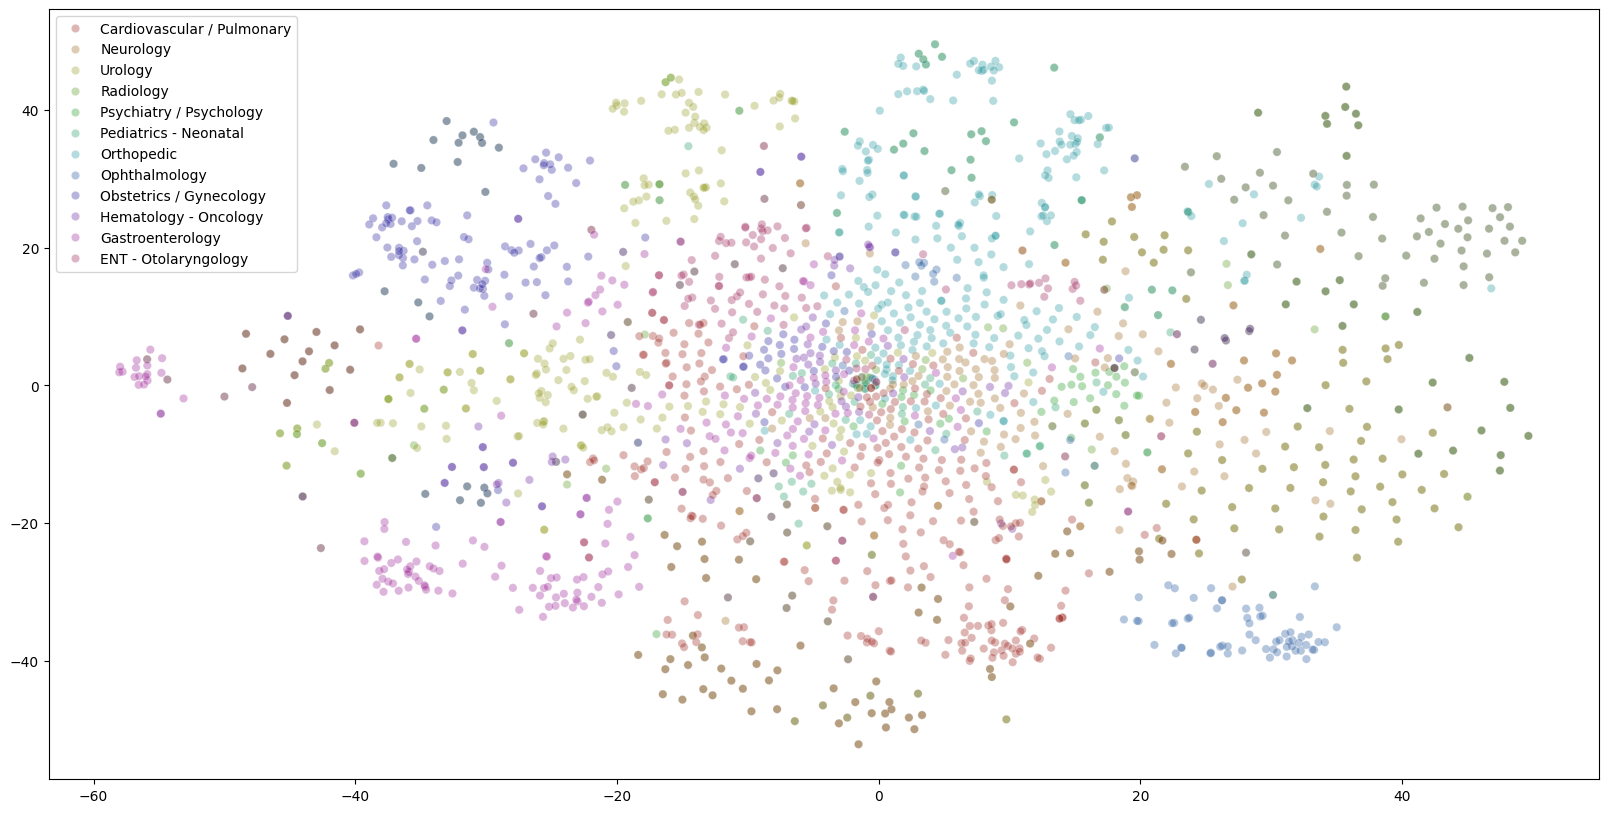

In [22]:
#plotting thee data points on 2d space using t_SNE dimentionality reduction
import gc
gc.collect()
tfIdfMatrix = np.asarray(tfIdfMat.todense())
labels = data['medical_specialty'].tolist()
tsne_results = TSNE(n_components=2,init='random',random_state=0, perplexity=40).fit_transform(tfIdfMatrix)
plt.figure(figsize=(20,10))
palette = sns.hls_palette(12, l=.3, s=.9)
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=labels,
    palette= palette,
    legend="full",
    alpha=0.3
)
plt.show()

In [23]:
# extracting first n principal components of the feature space which will cover 95% variance in input data
pca = PCA(n_components=0.95)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
labels = data['medical_specialty'].tolist()
category_list = data.medical_specialty.unique()

In [24]:
#checking dimension of reduceed space
tfIdfMat_reduced.shape

(2324, 582)

In [26]:
#splitting data into test train split
X_train, X_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, stratify=labels,random_state=1)
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(1743, 582)
Test_Set_Size:(581, 582)


In [27]:
#applyying logistic regressiion with elastic net regularization on train data and predicting class based on the trained model for X test
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
y_test_pred= clf.predict(X_test)

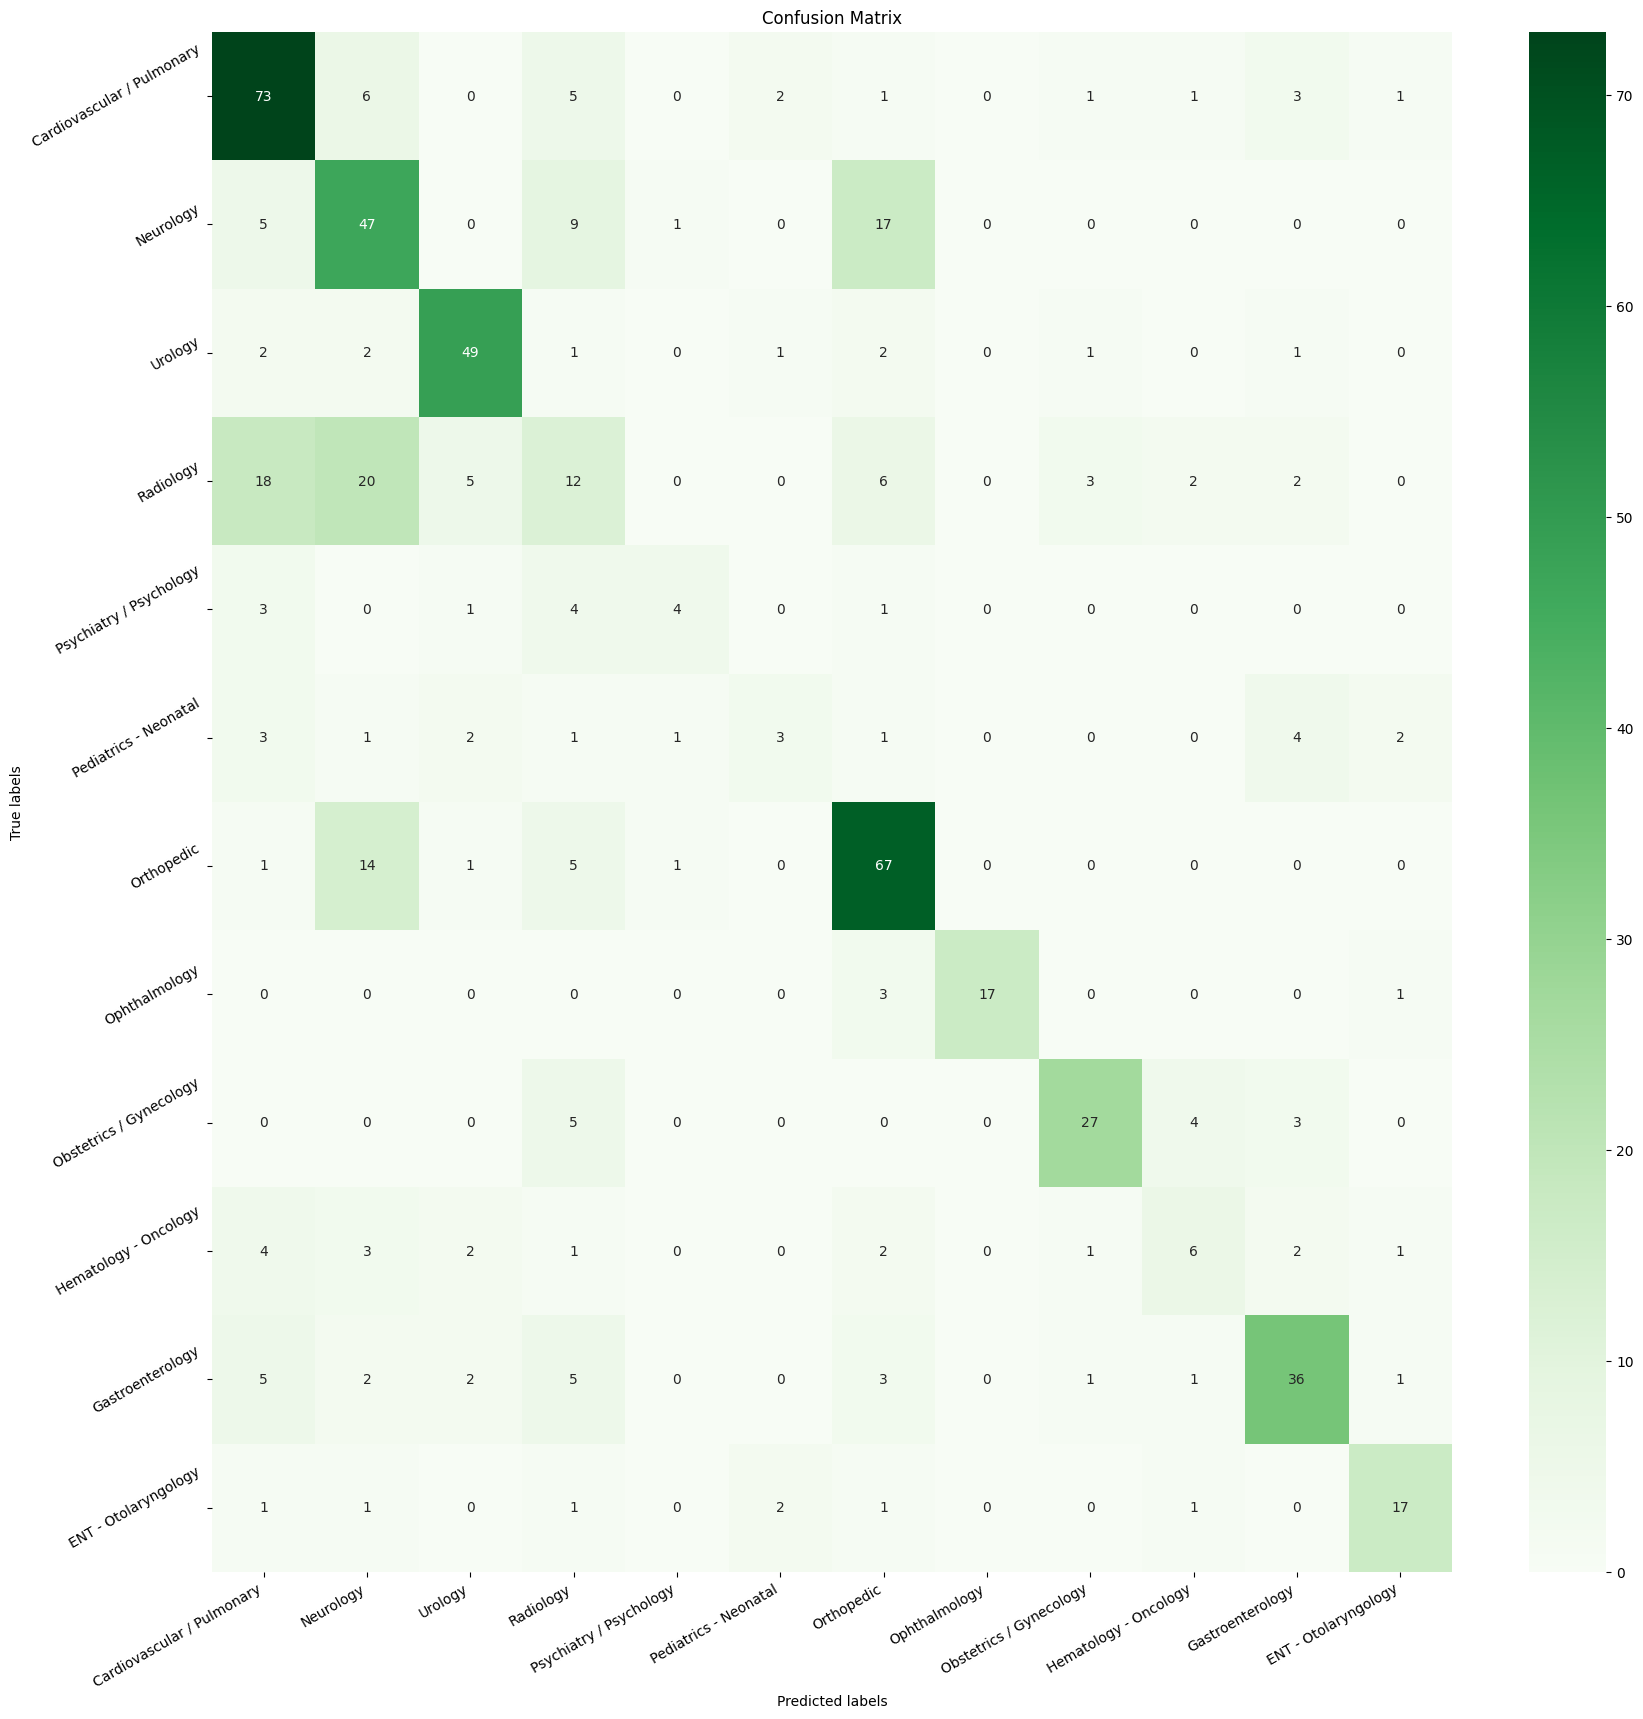

                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.63      0.78      0.70        93
                 Neurology       0.49      0.59      0.54        79
                   Urology       0.79      0.83      0.81        59
                 Radiology       0.24      0.18      0.21        68
   Psychiatry / Psychology       0.57      0.31      0.40        13
     Pediatrics - Neonatal       0.38      0.17      0.23        18
                Orthopedic       0.64      0.75      0.69        89
             Ophthalmology       1.00      0.81      0.89        21
   Obstetrics / Gynecology       0.79      0.69      0.74        39
     Hematology - Oncology       0.40      0.27      0.32        22
          Gastroenterology       0.71      0.64      0.67        56
      ENT - Otolaryngology       0.74      0.71      0.72        24

                  accuracy                           0.62       581
                 macro avg       0.62      0.5

In [41]:
#creating confusion matrix for the predicted classes and print the classification report
label = category_list
cm = confusion_matrix(y_test, y_test_pred, labels = label)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g');

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(label); ax.yaxis.set_ticklabels(label);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()
print(classification_report(y_test,y_test_pred,labels=category_list))

In [42]:
#addressing class imbalancee byy oversampling minority classes
smote_over_sample = SMOTE(sampling_strategy='minority')
labels = data['medical_specialty'].tolist()
X, y = smote_over_sample.fit_resample(tfIdfMat_reduced, labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,random_state=1)
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(1981, 582)
Test_Set_Size:(661, 582)


In [43]:
#applyying logistic regression on oversampled data
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
y_test_pred= clf.predict(X_test)

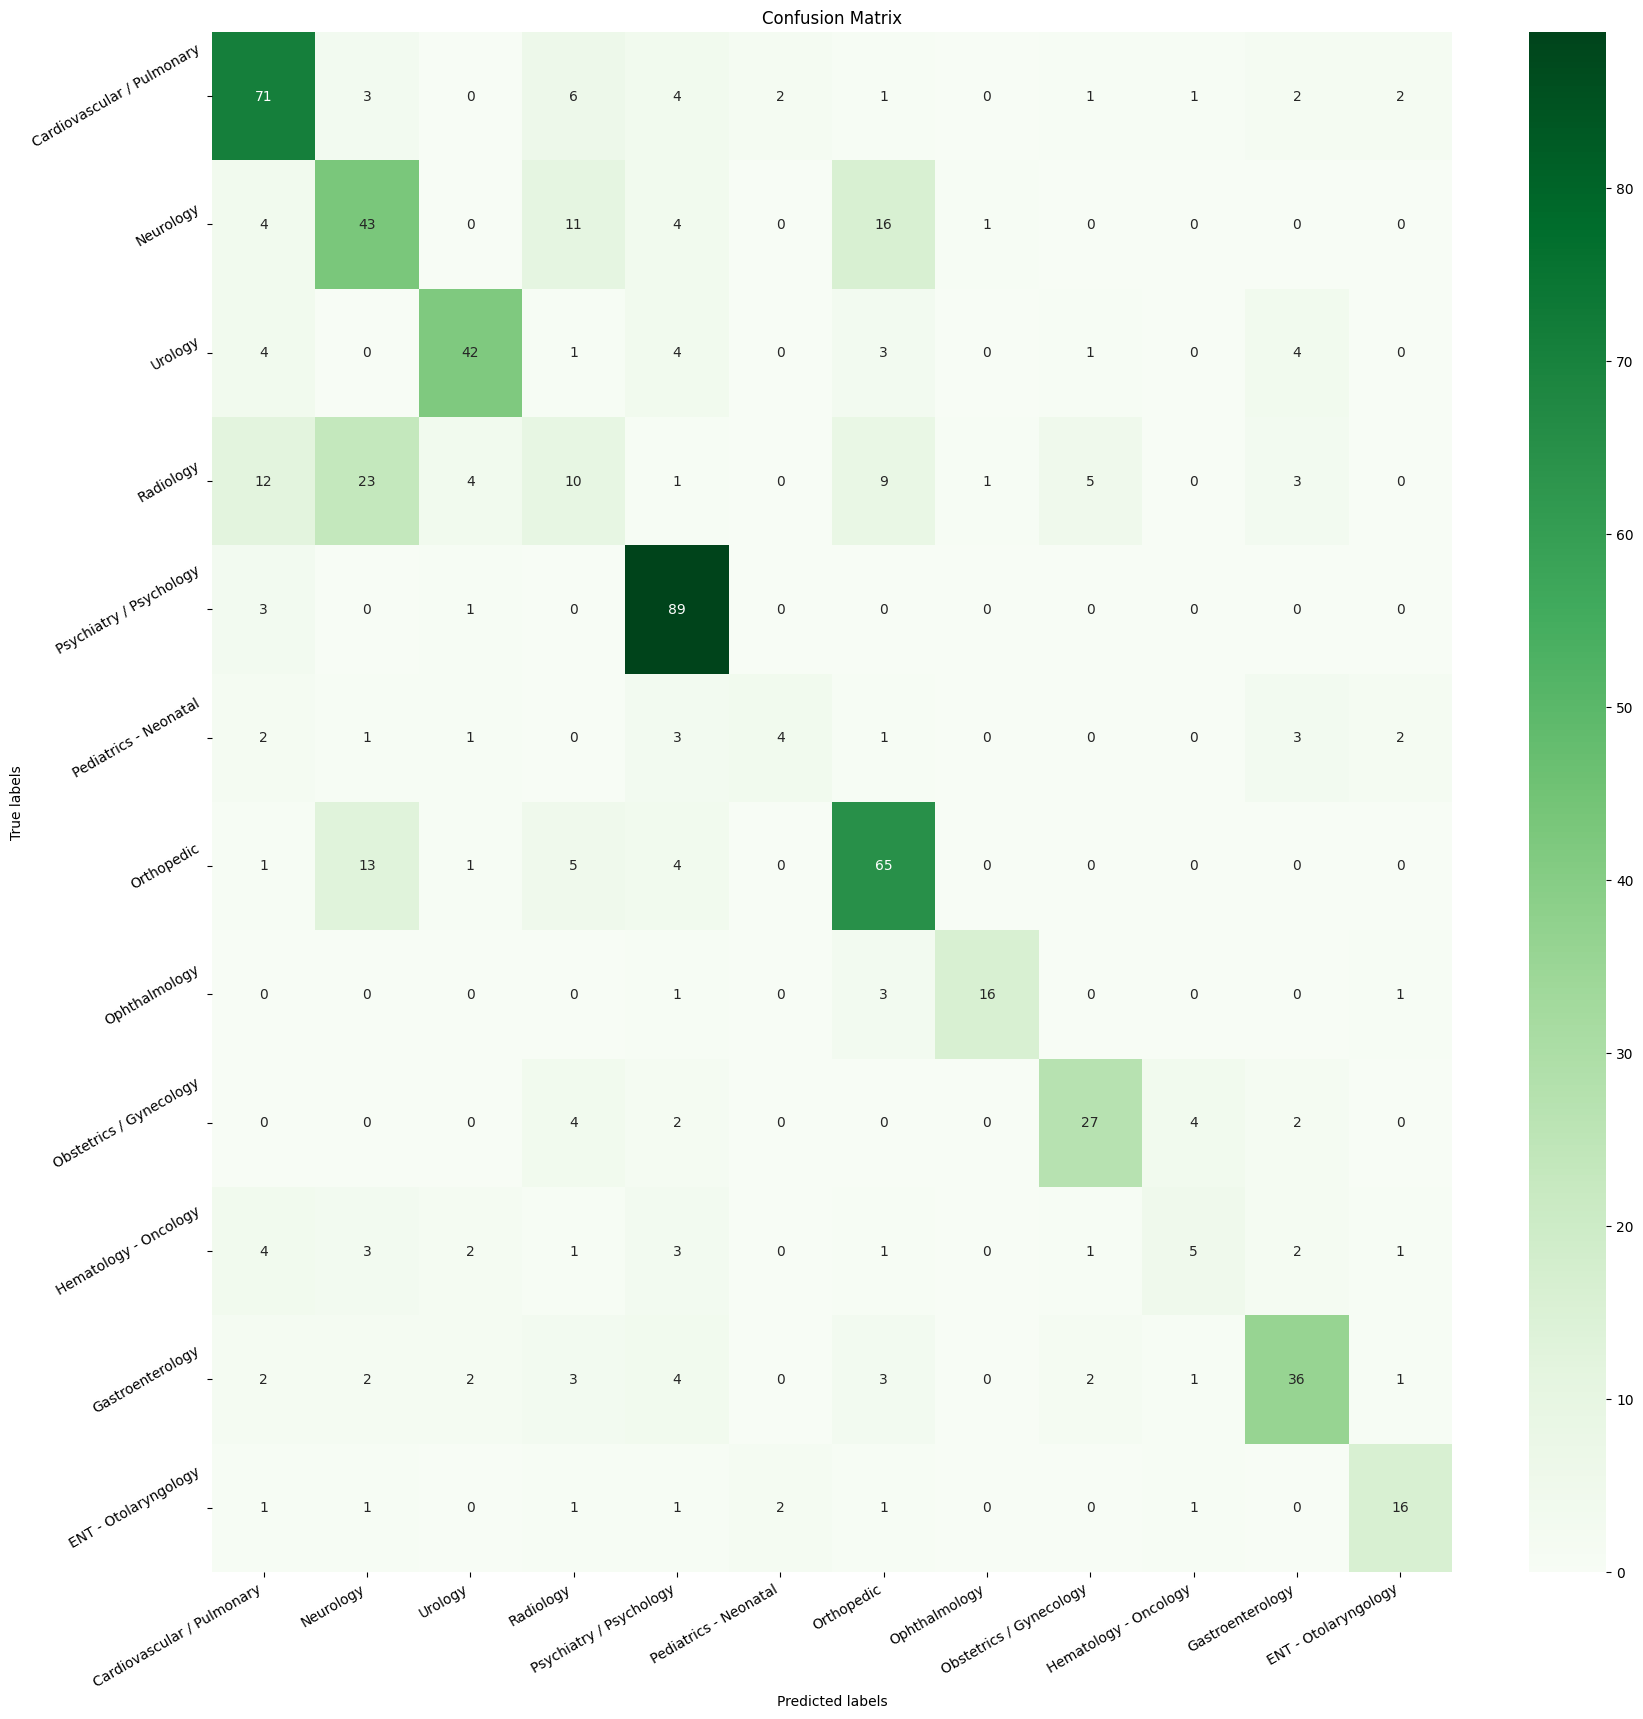

                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.68      0.76      0.72        93
                 Neurology       0.48      0.54      0.51        79
                   Urology       0.79      0.71      0.75        59
                 Radiology       0.24      0.15      0.18        68
   Psychiatry / Psychology       0.74      0.96      0.84        93
     Pediatrics - Neonatal       0.50      0.24      0.32        17
                Orthopedic       0.63      0.73      0.68        89
             Ophthalmology       0.89      0.76      0.82        21
   Obstetrics / Gynecology       0.73      0.69      0.71        39
     Hematology - Oncology       0.42      0.22      0.29        23
          Gastroenterology       0.69      0.64      0.67        56
      ENT - Otolaryngology       0.70      0.67      0.68        24

                  accuracy                           0.64       661
                 macro avg       0.62      0.5

In [44]:
label = category_list
cm = confusion_matrix(y_test, y_test_pred, labels = label)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g');

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(label); ax.yaxis.set_ticklabels(label);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()
print(classification_report(y_test,y_test_pred,labels=category_list))

In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create a base estimator (Random Forest classifier)
base_estimator = RandomForestClassifier(n_estimators=100, random_state=42)

# Create an ensemble classifier object with AdaBoost
ensemble_classifier = AdaBoostClassifier(base_estimator, n_estimators=50, random_state=42)

# Create an ensemble classifier object with Bagging
#ensemble_classifier = BaggingClassifier(base_estimator, n_estimators=50, random_state=42)

# Train the ensemble classifier using the training data (X_train, y_train)
ensemble_classifier.fit(X_train, y_train)

# Predict the target labels for the test data (X_test)
y_pred = ensemble_classifier.predict(X_test)



Accuracy: 0.5703479576399395
Classification Report:
                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.49      0.75      0.60        93
      ENT - Otolaryngology       0.74      0.71      0.72        24
          Gastroenterology       0.74      0.62      0.68        56
     Hematology - Oncology       0.00      0.00      0.00        23
                 Neurology       0.40      0.41      0.40        79
   Obstetrics / Gynecology       0.69      0.64      0.67        39
             Ophthalmology       0.89      0.76      0.82        21
                Orthopedic       0.55      0.62      0.58        89
     Pediatrics - Neonatal       0.00      0.00      0.00        17
   Psychiatry / Psychology       0.86      0.97      0.91        93
                 Radiology       0.00      0.00      0.00        68
                   Urology       0.86      0.63      0.73        59

                  accuracy                           0.57     

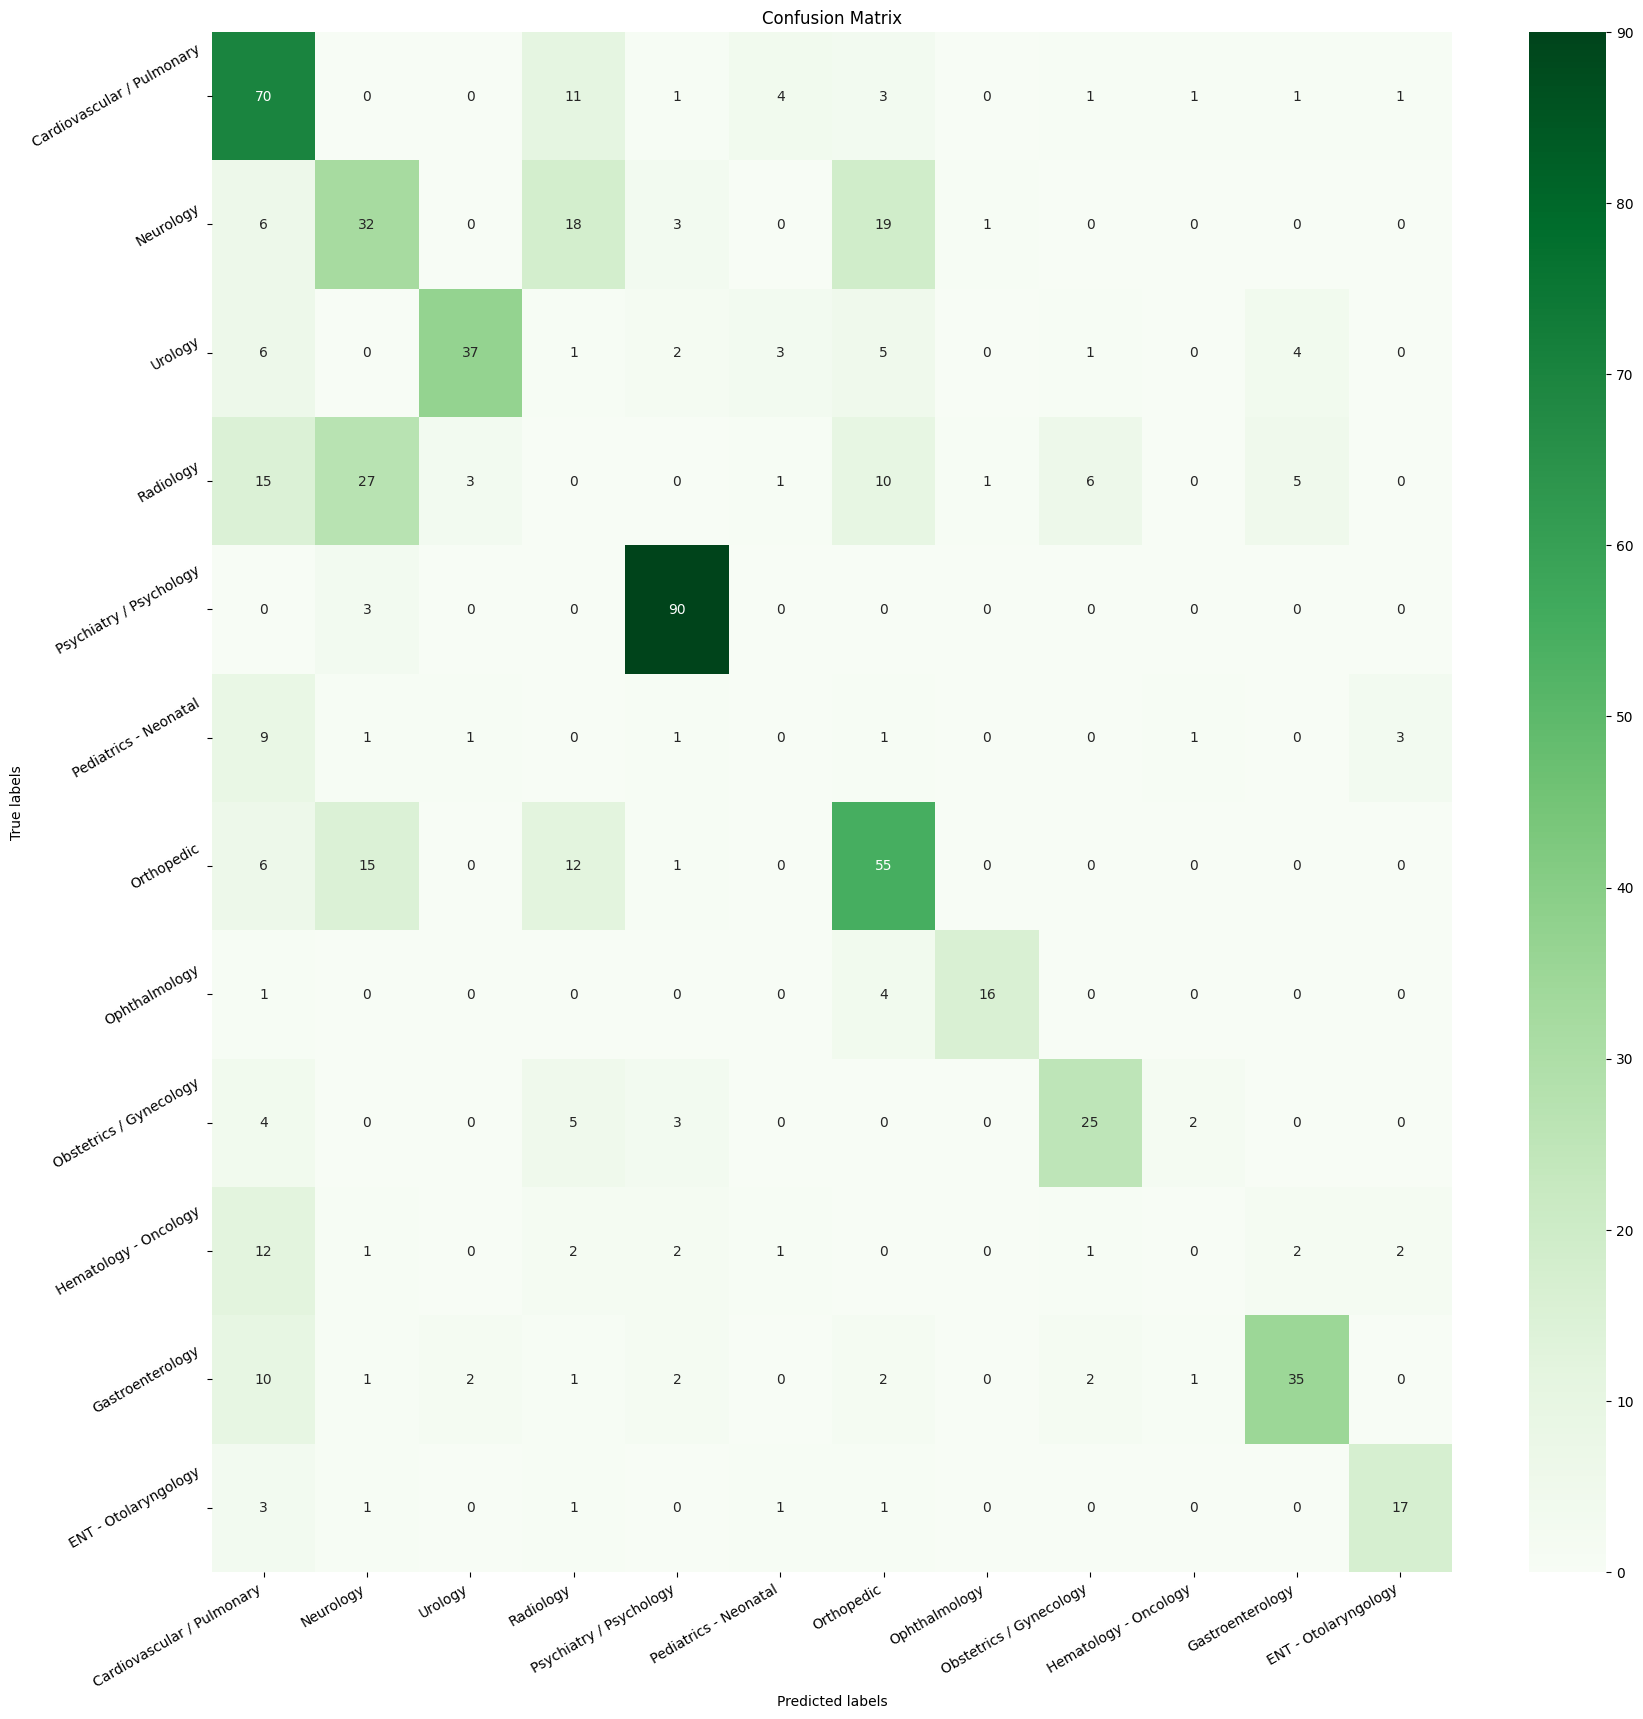

In [ ]:

#Evaluate the performance of the ensemble classifier with bagging
print("Classification Report:")
print(classification_report(y_test, y_pred))


# Confusion matrix
print("Confusion Matrix:")
label = category_list
cm = confusion_matrix(y_test, y_pred, labels = label)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g');

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(label); ax.yaxis.set_ticklabels(label);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

Accuracy: 0.4750378214826021
Classification Report:
                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.33      0.80      0.47        93
      ENT - Otolaryngology       0.50      0.21      0.29        24
          Gastroenterology       0.78      0.45      0.57        56
     Hematology - Oncology       0.00      0.00      0.00        23
                 Neurology       0.34      0.23      0.27        79
   Obstetrics / Gynecology       0.64      0.41      0.50        39
             Ophthalmology       1.00      0.19      0.32        21
                Orthopedic       0.48      0.66      0.55        89
     Pediatrics - Neonatal       0.00      0.00      0.00        17
   Psychiatry / Psychology       0.95      0.97      0.96        93
                 Radiology       0.00      0.00      0.00        68
                   Urology       0.77      0.39      0.52        59

                  accuracy                           0.48     

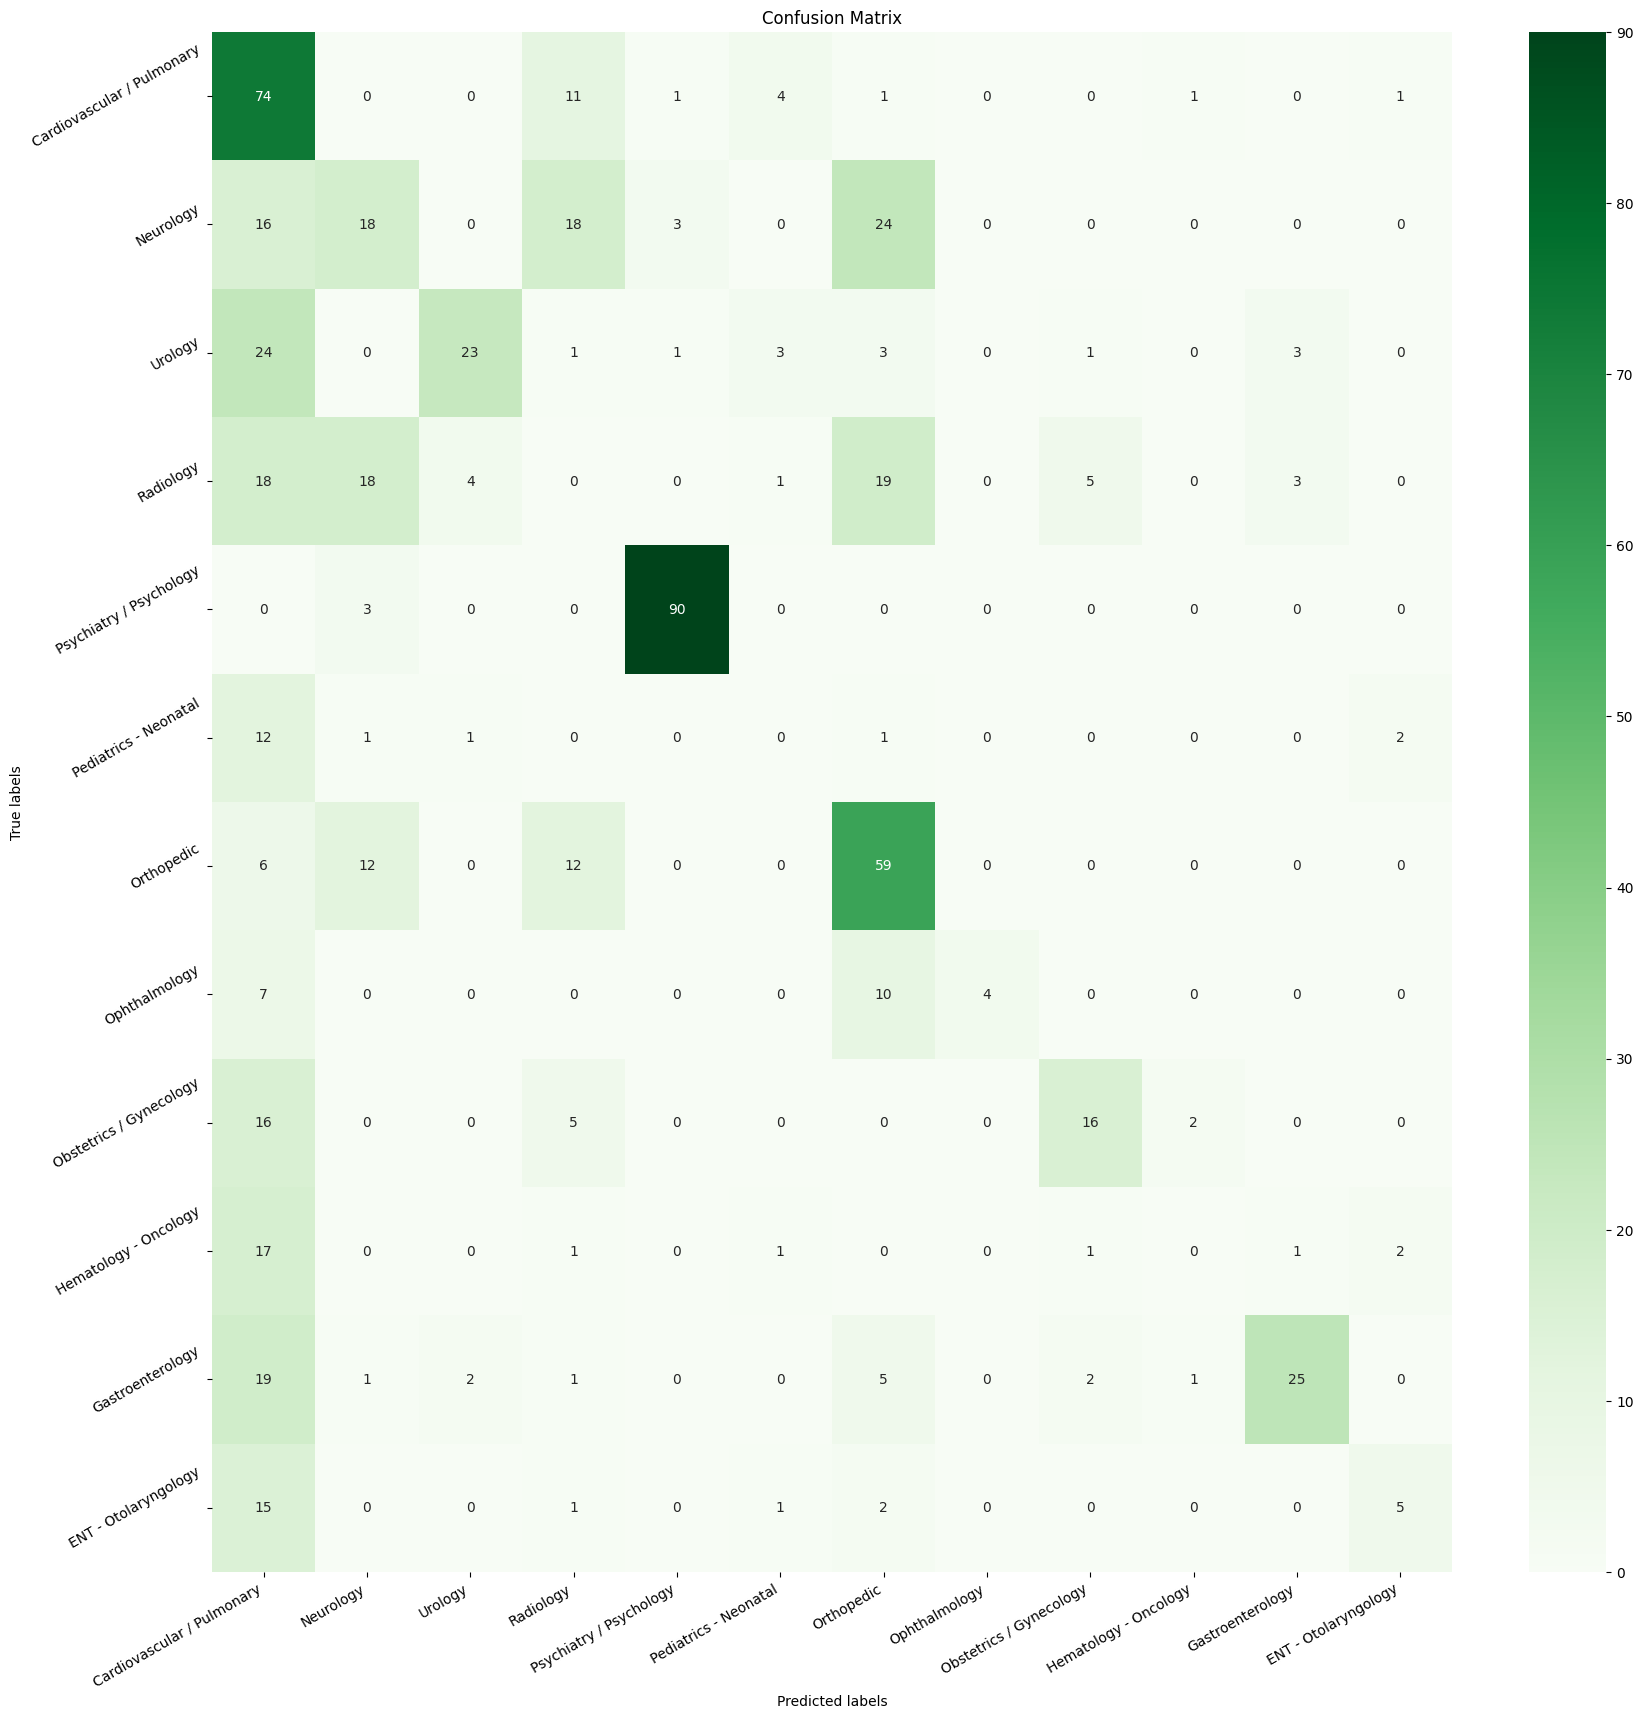

In [ ]:

# 5. Evaluate the performance of the ensemble classifier with adaboost
print("Classification Report:")
print(classification_report(y_test, y_pred))


# Confusion matrix
print("Confusion Matrix:")
label = category_list
cm = confusion_matrix(y_test, y_pred, labels = label)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g');
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(label); ax.yaxis.set_ticklabels(label);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create an SVM classifier object with the desired kernel function
svm_classifier = SVC(kernel='rbf')

# Train the classifier using the training data (X_train, y_train)
svm_classifier.fit(X_train, y_train)

# Predict the target labels for the test data (X_test)
y_pred = svm_classifier.predict(X_test)



Accuracy: 0.6293494704992436
Classification Report:
                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.65      0.74      0.69        93
      ENT - Otolaryngology       0.71      0.71      0.71        24
          Gastroenterology       0.72      0.64      0.68        56
     Hematology - Oncology       0.50      0.22      0.30        23
                 Neurology       0.42      0.48      0.45        79
   Obstetrics / Gynecology       0.72      0.72      0.72        39
             Ophthalmology       1.00      0.90      0.95        21
                Orthopedic       0.64      0.65      0.64        89
     Pediatrics - Neonatal       0.36      0.24      0.29        17
   Psychiatry / Psychology       0.93      1.00      0.96        93
                 Radiology       0.08      0.07      0.08        68
                   Urology       0.80      0.75      0.77        59

                  accuracy                           0.63     

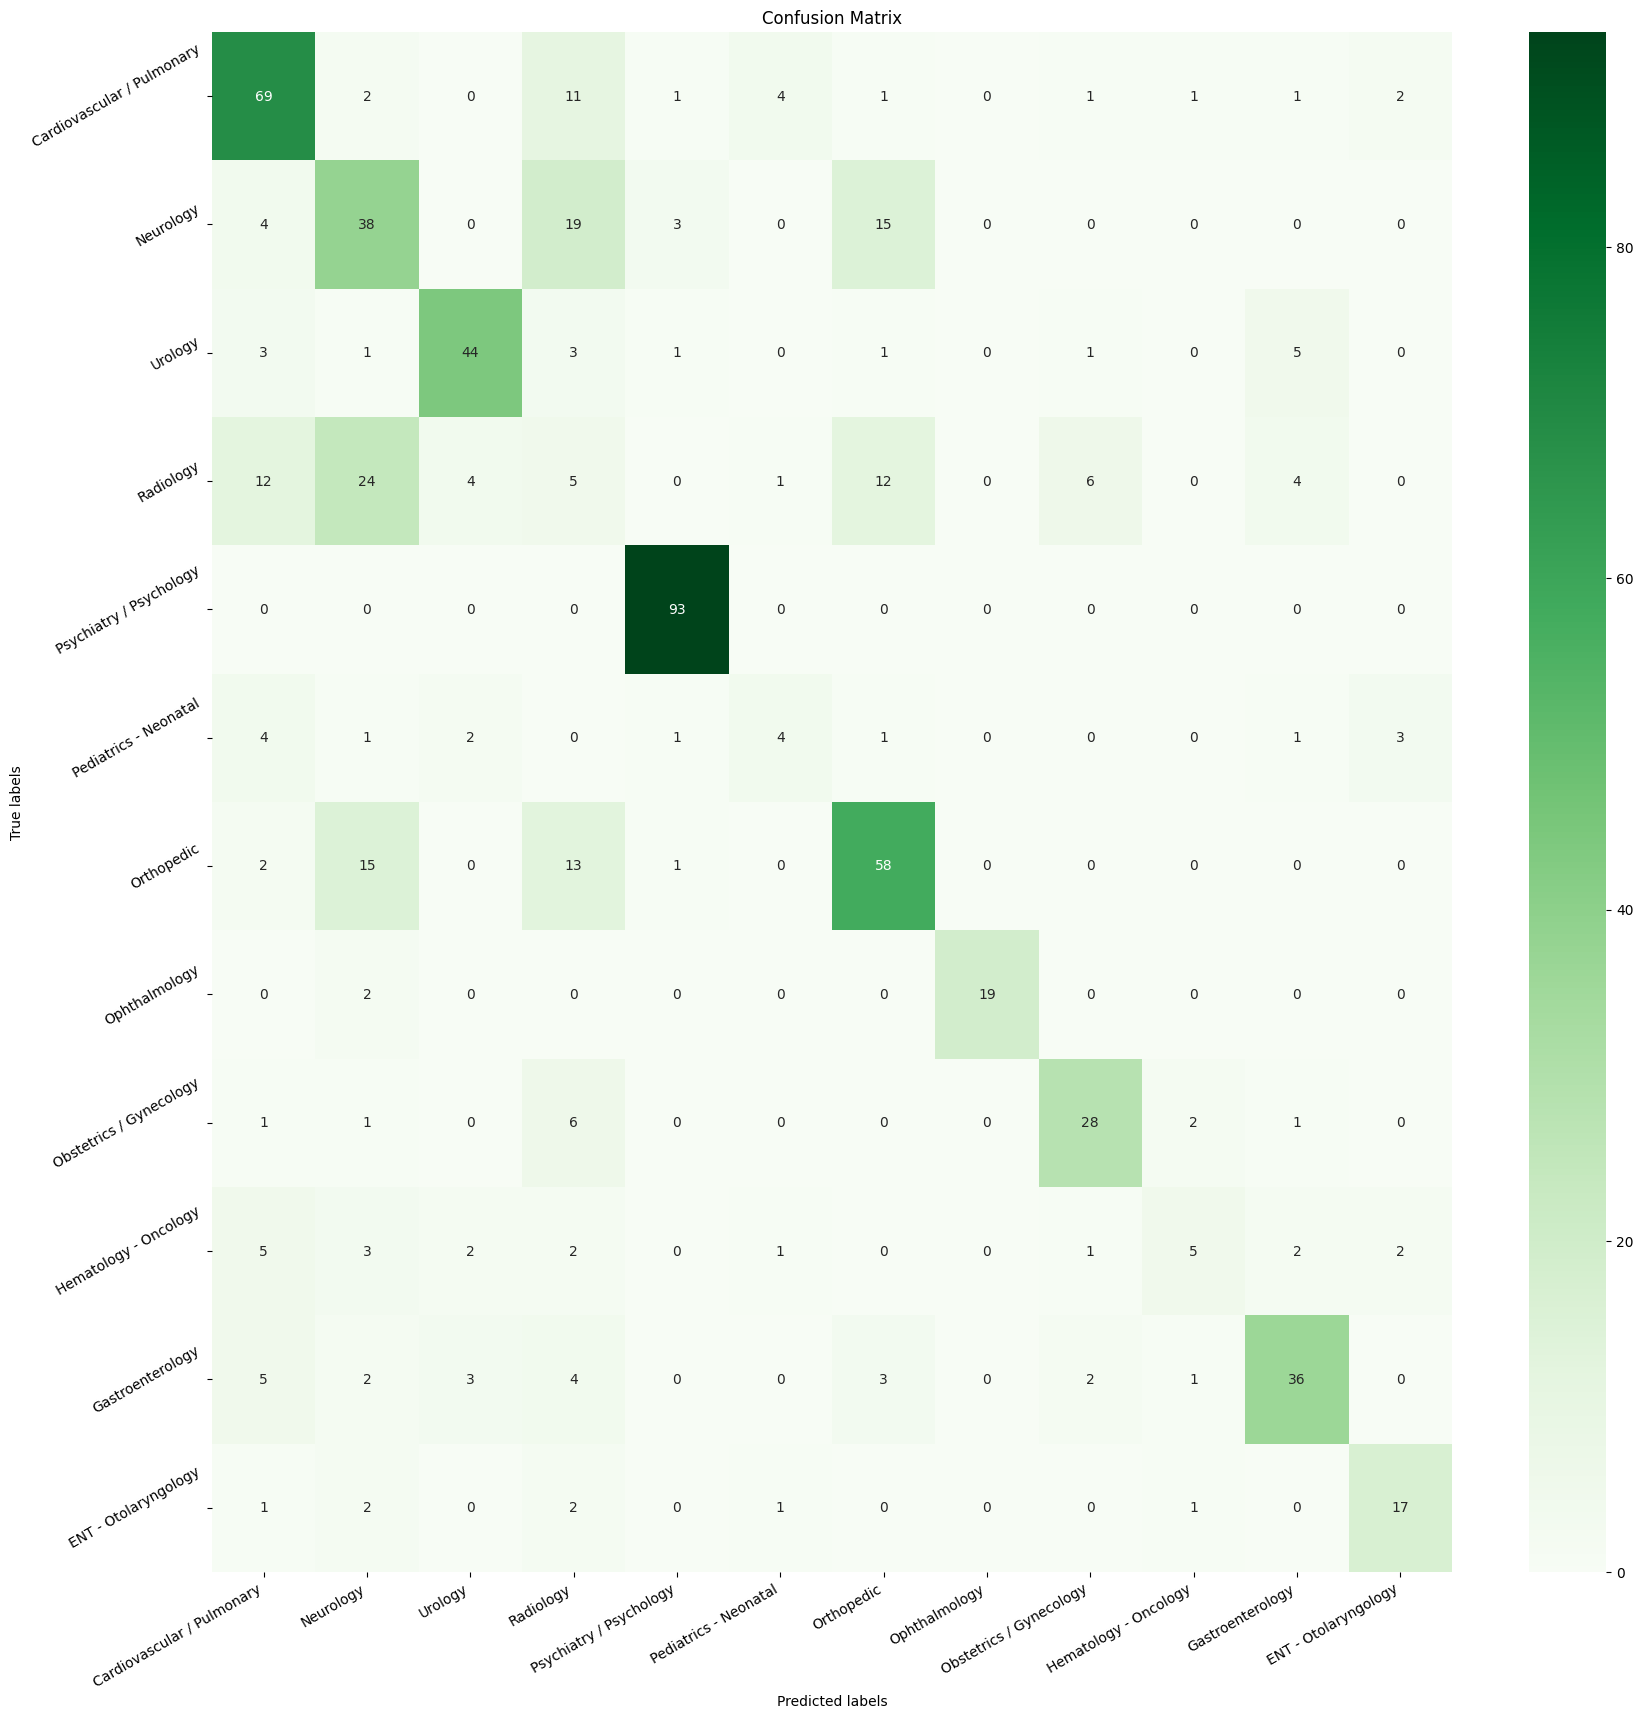

In [ ]:
# Evaluate the performance of the classifier
print("Classification Report:")
print(classification_report(y_test, y_pred))


# Confusion matrix
print("Confusion Matrix:")
label = category_list
cm = confusion_matrix(y_test, y_pred, labels = label)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g');

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(label); ax.yaxis.set_ticklabels(label);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

In [45]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Defining parameter grid
param_grid = {
    'C': [0.1, 1, 10],                # Regularization parameter
    'gamma': [0.01, 0.1, 1],           # Kernel coefficient for 'rbf' kernel
    'kernel': ['rbf', 'linear']        # Type of kernel function
}

# Instantiate an SVM classifier
svm_classifier = SVC()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Retrieve the best hyperparameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   1.5s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   1.7s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   1.3s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   1.2s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   1.2s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.9s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.9s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.9s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.9s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.9s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   1.2s
[CV] END .......................C=0.1, gamma=0.1

Best Hyperparameters: {'C': 1, 'gamma': 0.01, 'kernel': 'linear'}
Accuracy: 0.649016641452345
Classification Report:
                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.66      0.75      0.70        93
      ENT - Otolaryngology       0.73      0.79      0.76        24
          Gastroenterology       0.67      0.64      0.65        56
     Hematology - Oncology       0.57      0.35      0.43        23
                 Neurology       0.53      0.54      0.54        79
   Obstetrics / Gynecology       0.71      0.74      0.72        39
             Ophthalmology       1.00      0.86      0.92        21
                Orthopedic       0.65      0.72      0.68        89
     Pediatrics - Neonatal       0.45      0.29      0.36        17
   Psychiatry / Psychology       0.83      0.97      0.89        93
                 Radiology       0.09      0.06      0.07        68
                   Urology       0.78      0.73      0.75        5

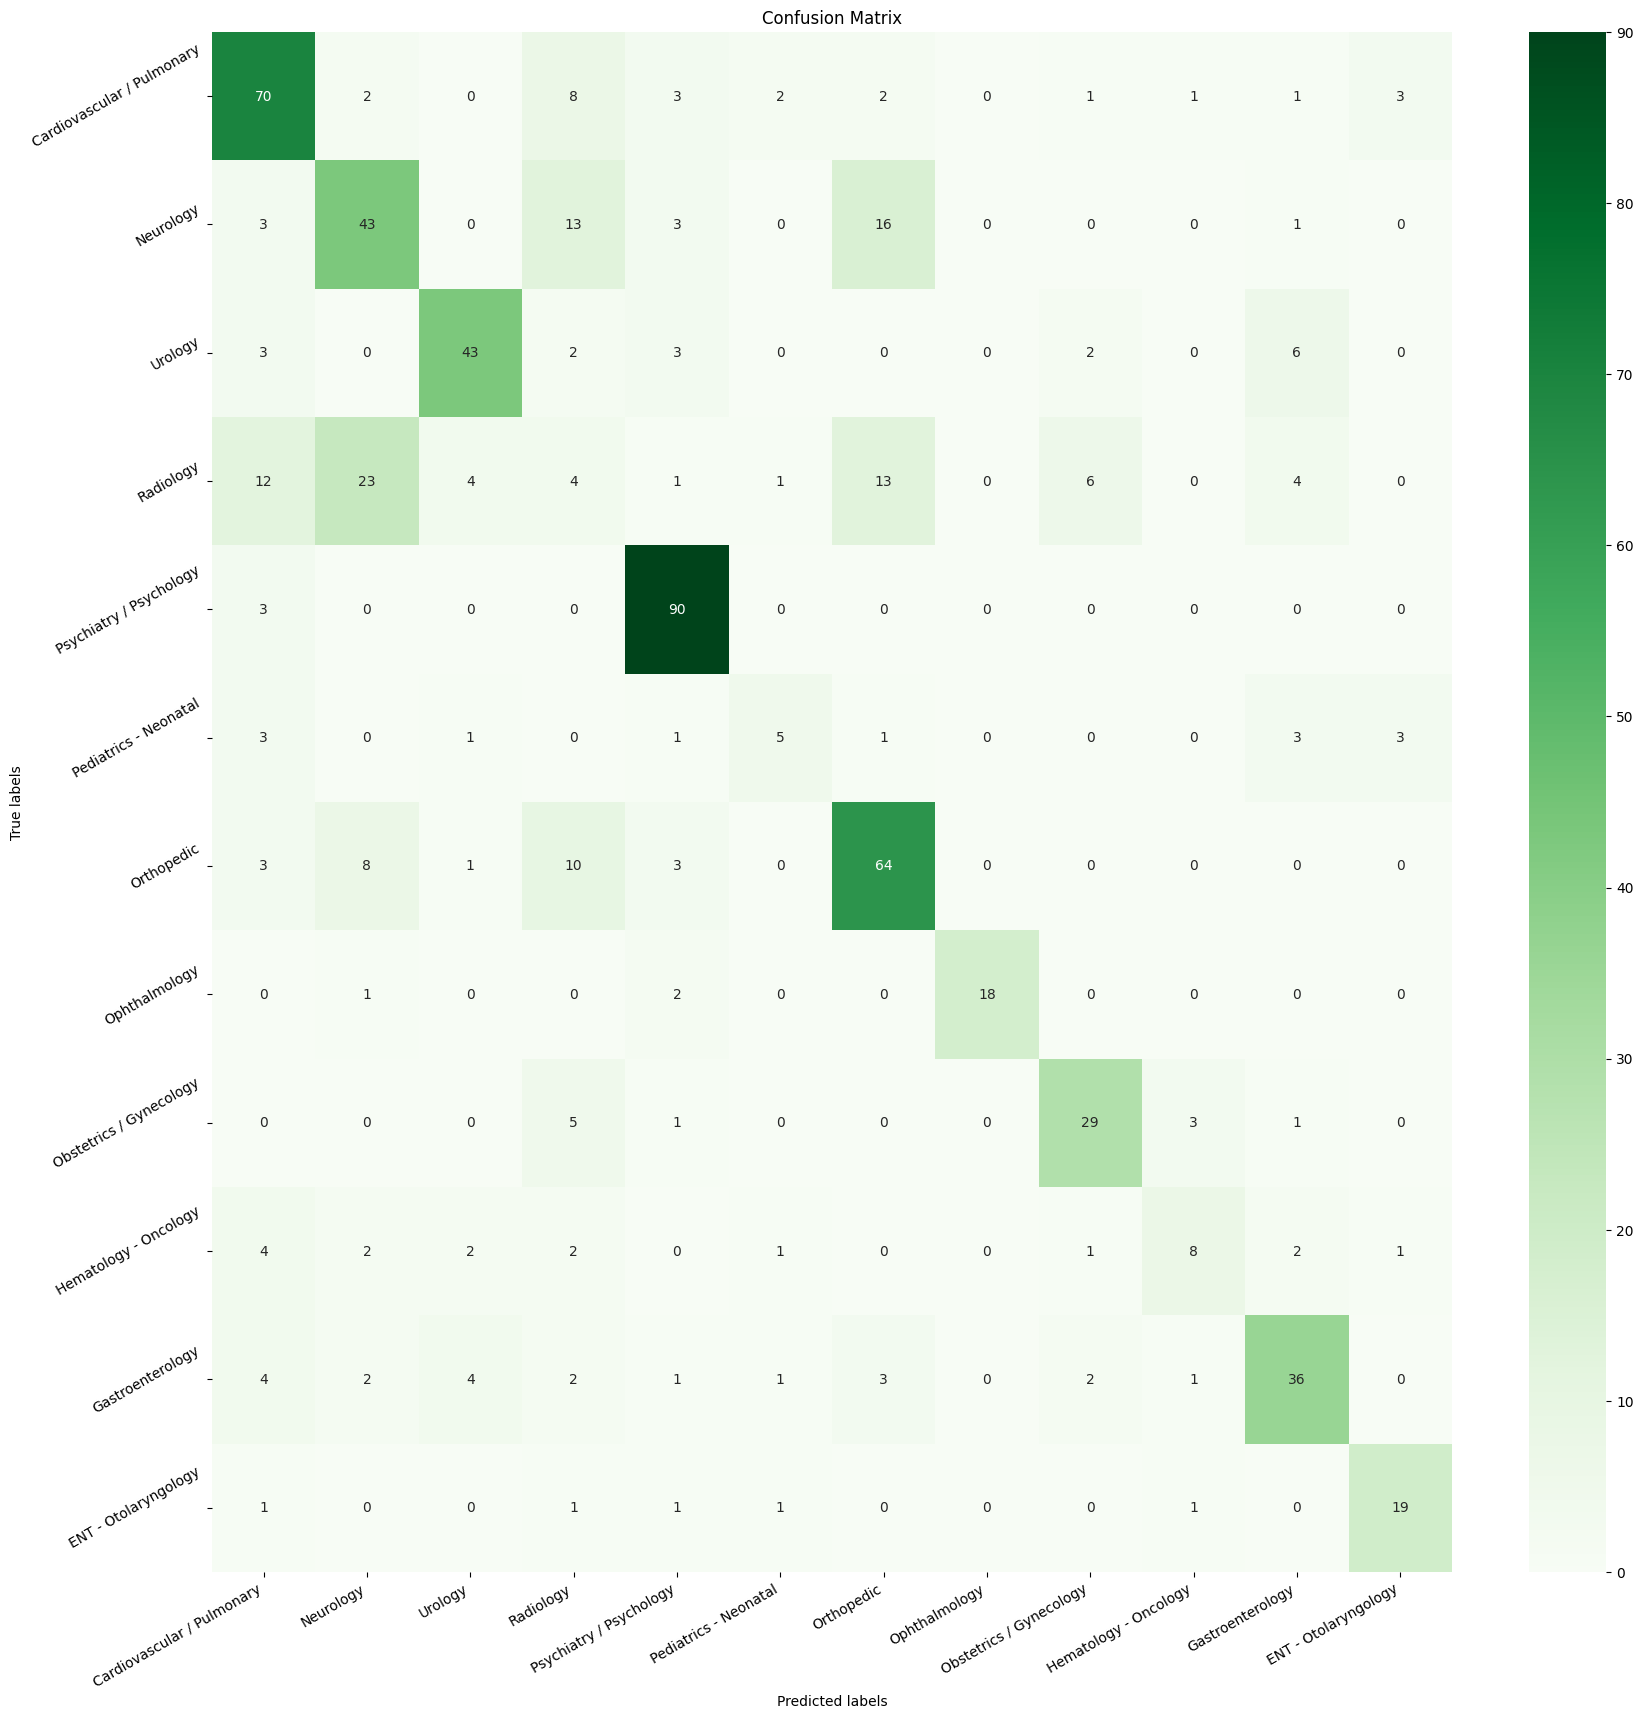

In [46]:
# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))
# Confusion matrix
print("Confusion Matrix:")
label = category_list
cm = confusion_matrix(y_test, y_pred, labels = label)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g');
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(label); ax.yaxis.set_ticklabels(label);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

In [37]:
from IPython.display import display, HTML

# Define the desired height for the output cell (in pixels)
height_px = 300

# Generate HTML code to set the height of the output area
display(HTML(f"<style>.output {{ max-height: {height_px}px !important; }}</style>"))
